In [1]:
pip install --upgrade tensorflow tensorflow-io

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement keras<2.16,>=2.15.0 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for keras<2.16,>=2.15.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

2024-06-26 22:33:26.380857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 22:33:26.380991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 22:33:26.559683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [4]:
from sklearn.utils import shuffle
import os
import cv2
import numpy as np

# Function for importing data and labels with preprocessing
def get_data_labels(directory, img_size=(224, 224), shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types. This version includes
    image preprocessing for consistent input to the model.
    """
    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            
            # Read and preprocess the image
            img = cv2.imread(image_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalizing the image
            
            data_path.append(img)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return np.array(data_path), np.array(data_labels)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up file paths for training and testing
USER_PATH = r"/kaggle/input/brain-tumor-mri-dataset"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Creating an instance of the ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1./255)

# Creating generators for training and testing data
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Printing training and testing sample sizes
print('Training')
print(f'Number of Batches: {len(train_generator)}')
print(f'Number of Labels: {len(train_generator.classes)}')
print('\nTesting')
print(f'Number of Batches: {len(test_generator)}')
print(f'Number of Labels: {len(test_generator.classes)}')


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training
Number of Batches: 179
Number of Labels: 5712

Testing
Number of Batches: 41
Number of Labels: 1311


Training Counts
{'glioma_tumor': 1321, 'meningioma_tumor': 1339, 'no_tumor': 1595, 'pituitary_tumor': 1457}

Testing Counts
{'glioma_tumor': 300, 'meningioma_tumor': 306, 'no_tumor': 405, 'pituitary_tumor': 300}


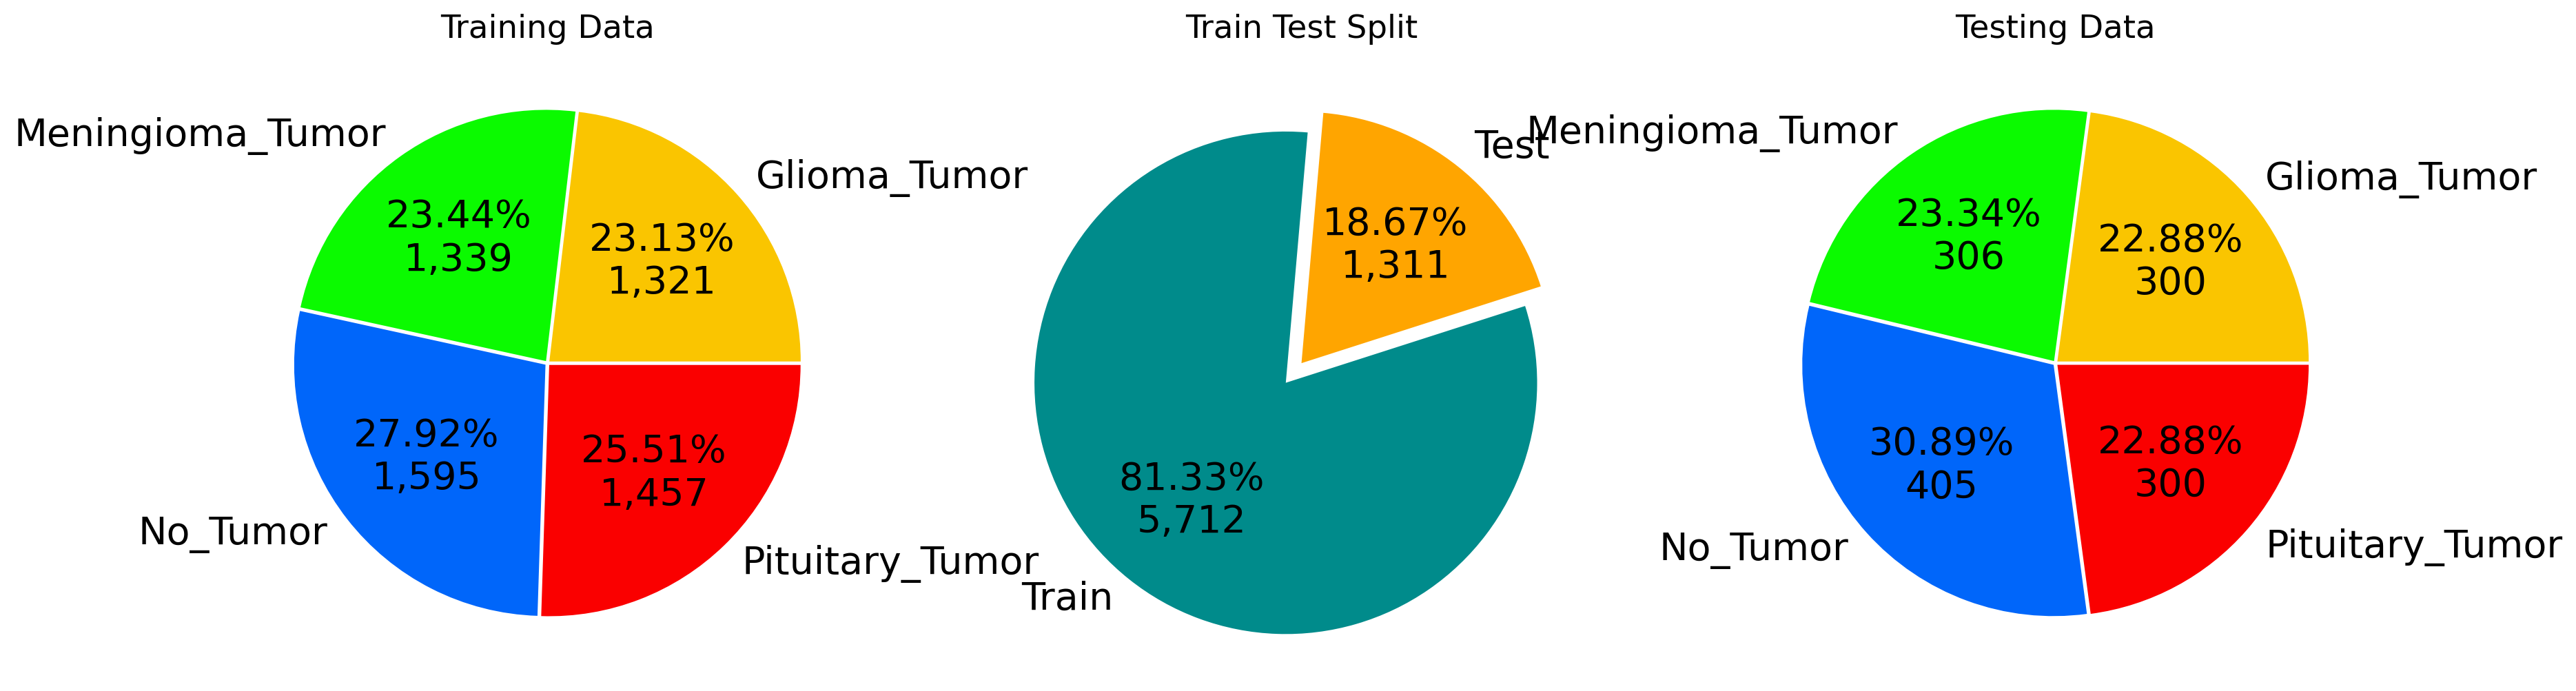

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming CLASS_TYPES is defined and corresponds to the class indices used by the generator
CLASS_TYPES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Example class names
N_TYPES = len(CLASS_TYPES)

_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
train_counter = Counter(train_generator.classes)
train_class_counts = [train_counter[i] for i in range(N_TYPES)]
print('Training Counts')
print(dict(zip(CLASS_TYPES, train_class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    train_class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(train_class_counts) / 100),
    explode=tuple(0.01 for _ in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_generator.classes), len(test_generator.classes)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * (len(train_generator.classes) + len(test_generator.classes)) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
test_counter = Counter(test_generator.classes)
test_class_counts = [test_counter[i] for i in range(N_TYPES)]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, test_class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    test_class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(test_class_counts) / 100),
    explode=tuple(0.01 for _ in range(N_TYPES)),
    textprops={'fontsize': 20}
)

plt.show()


Image reshaped to: (1, 224, 224, 3)


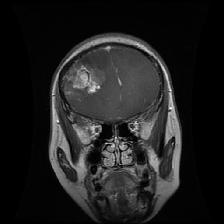

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np

# Assuming you have a train_generator object from ImageDataGenerator
# Get the file paths from the generator
file_paths = train_generator.filepaths

# Choose an image path, for example, the first image in the dataset
image_path = file_paths[0]

# Load and preprocess the image
# Replace 'target_size' with the size expected by your model
im = load_img(image_path, target_size=(224, 224))  # Adjust target_size to match model input
im = img_to_array(im)  # Convert the image to an array

# Reshape it to the required input shape for the model, e.g., (1, 224, 224, 3)
im = np.expand_dims(im, axis=0)
print(f'Image reshaped to: {im.shape}')

# Normalize the image tensor by dividing by the maximum pixel value
im /= np.max(im)

# Convert the array back to the image format for display
im = array_to_img(im[0])
display(im)  # Ensure this integrates well with your application's UI


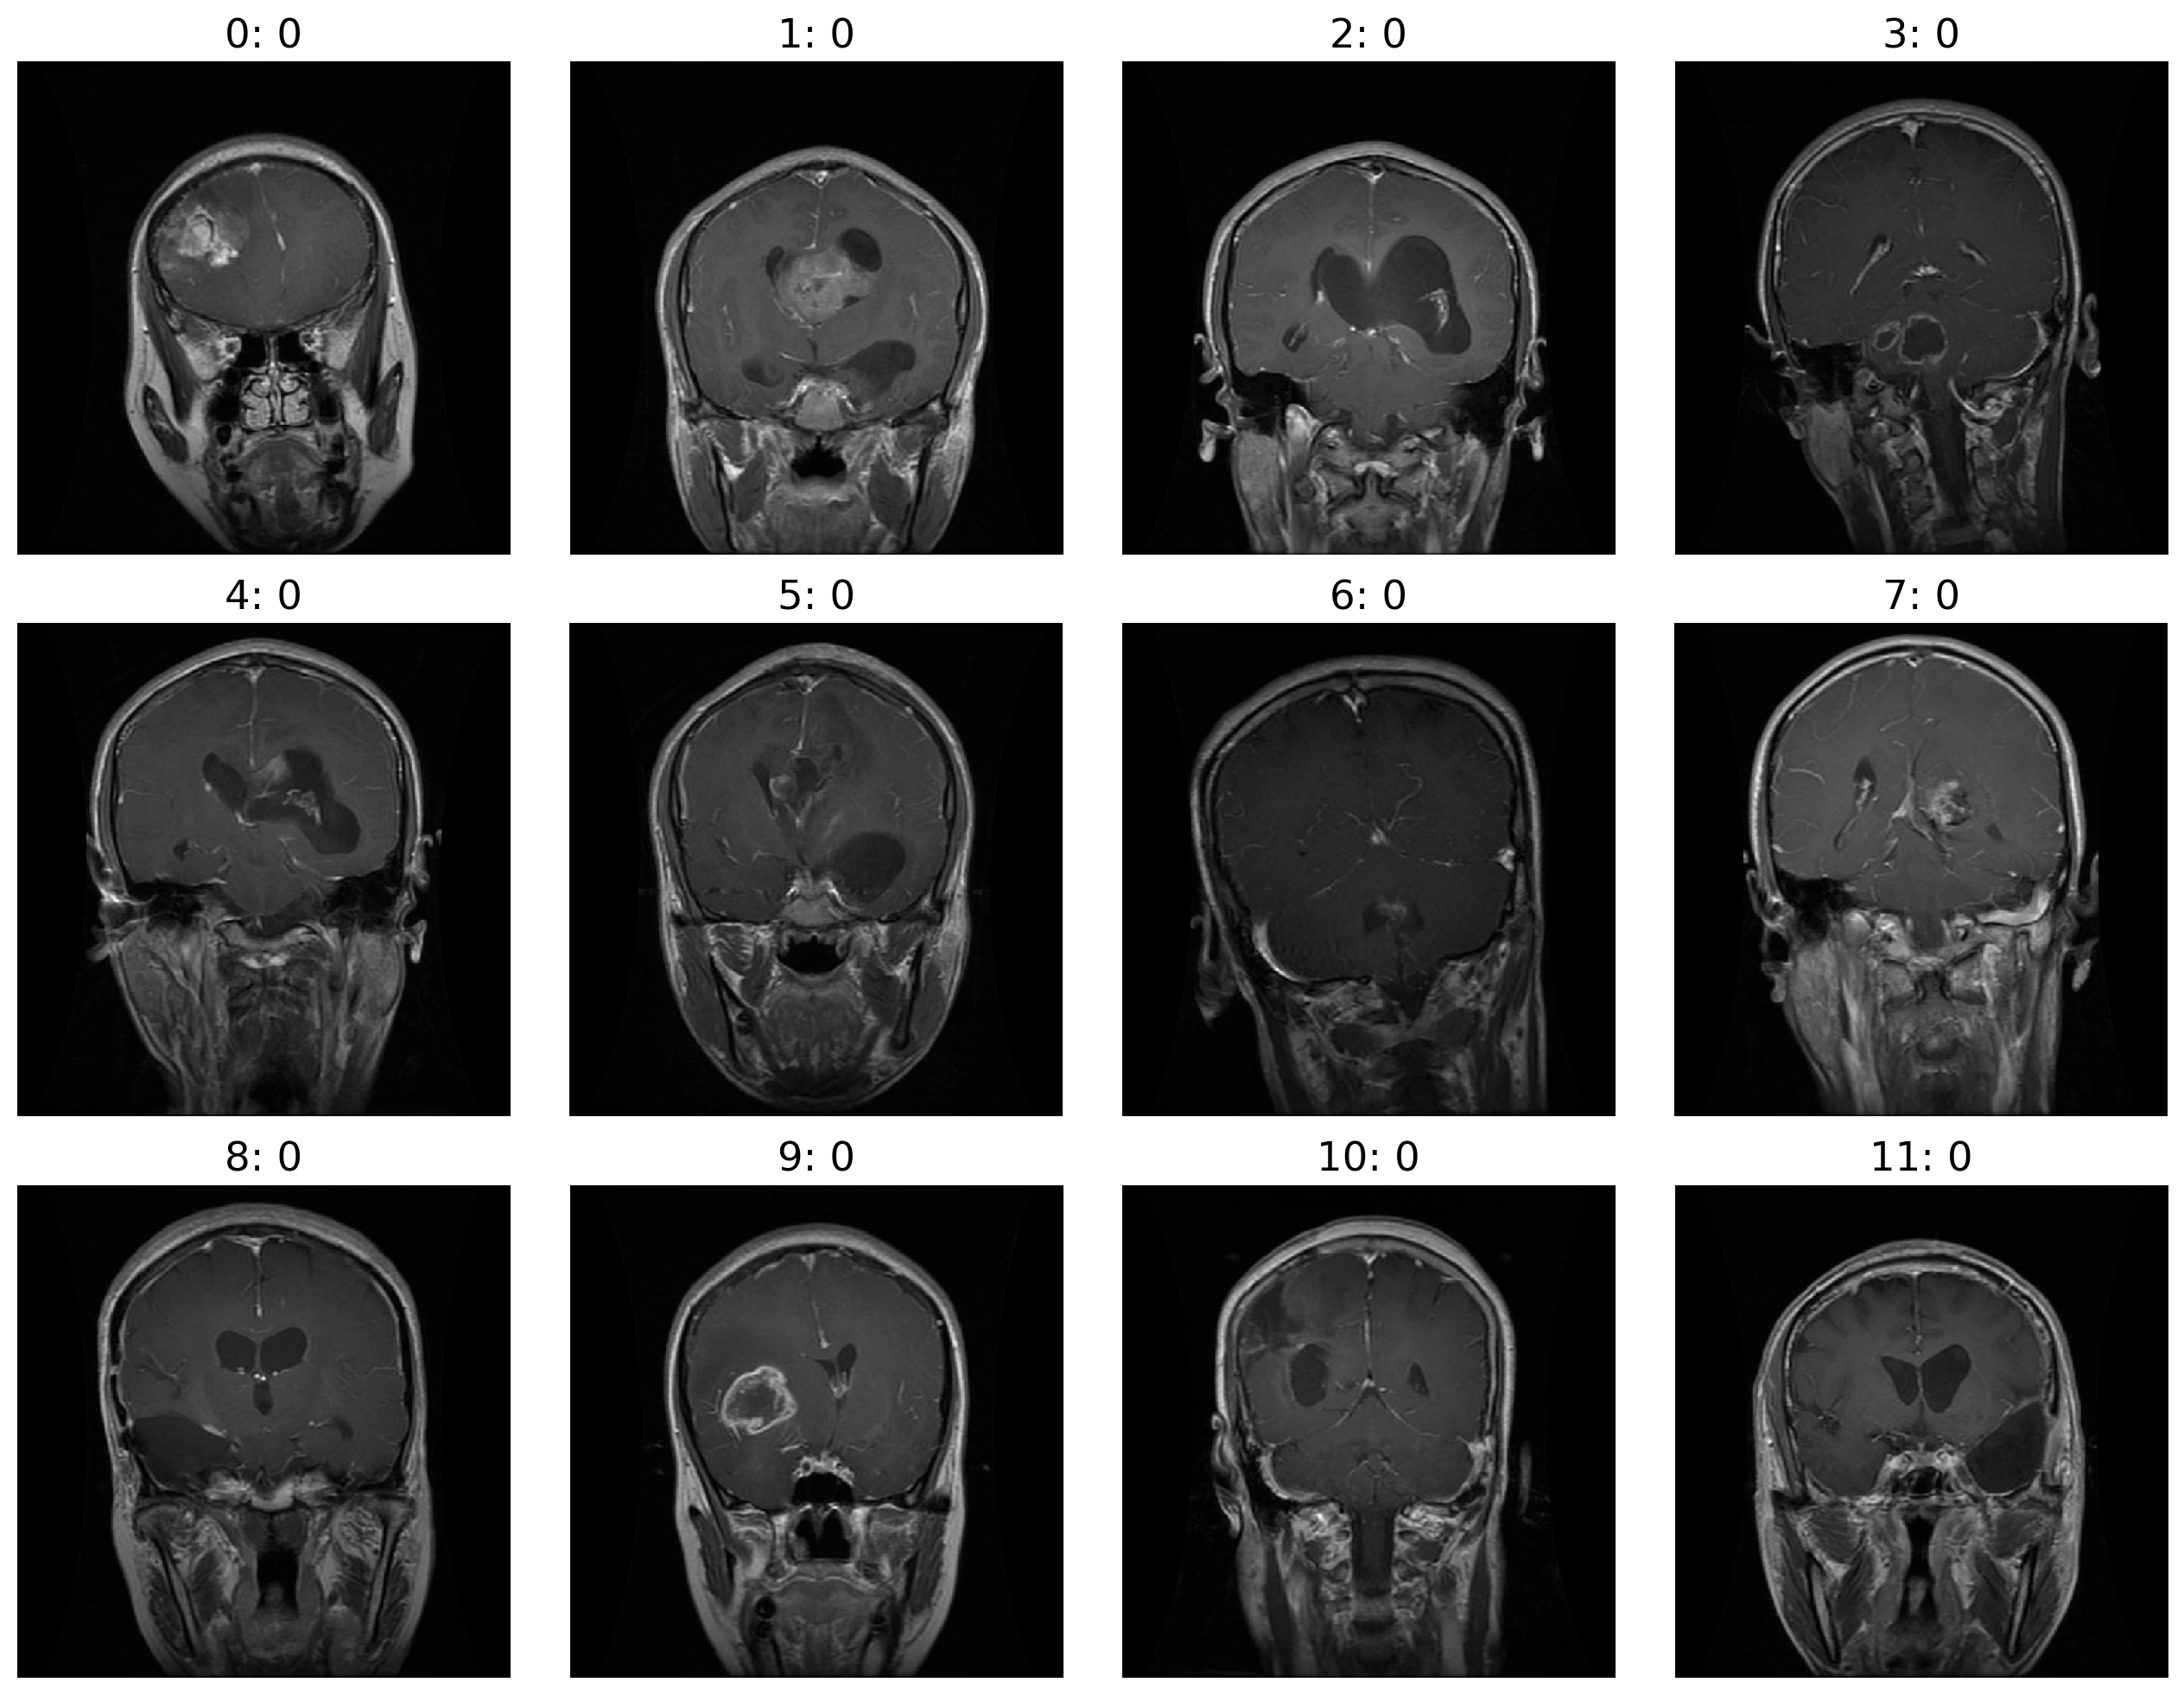

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Function to display a list of images based on the given index
def show_images(generator, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a generator based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        # Get the file path and label from the generator
        image_path = generator.filepaths[index]
        label = generator.classes[index]
        
        # Load and display the image
        image = load_img(image_path, target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

# Example usage with the train_generator
# Display the first 12 images from the training set
show_images(train_generator, im_size=350, figsize=(13,10), index_list=range(12))


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants for reproducibility
SEED = 42  # Replace with your constant seed value

# Image size
image_size = (150, 150)  # Consider increasing this if your model can handle larger images

# Training batch size
batch_size = 32  # Adjust based on your GPU memory

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Slightly increased rotation
    brightness_range=(0.8, 1.2),  # Slightly wider brightness range
    width_shift_range=0.05,  # Increased shift range
    height_shift_range=0.05,  # Increased shift range
    shear_range=0.1,  # Reduced shear range
    zoom_range=0.1,  # Added zoom range
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

# Applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=SEED
)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


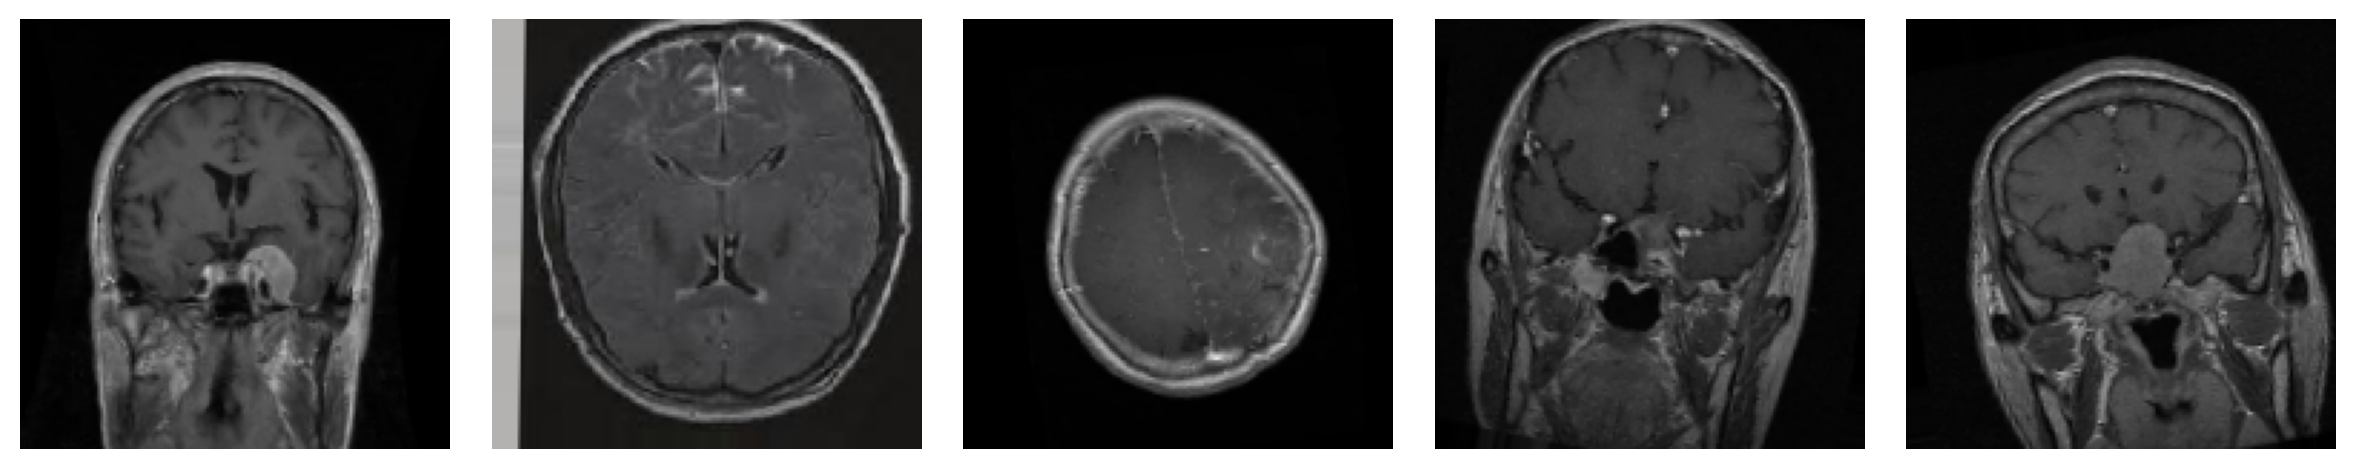

In [10]:
import matplotlib.pyplot as plt

def show_ImageDataGenerator(generator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to visualize how the ImageDataGenerator augments the data.
    """
    
    # Generate augmented samples using the next() function
    augmented_samples = next(generator)

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        # Convert the image array to a displayable format
        image = (images[i] * 255).astype('uint8')
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()

# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())

# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

# Example usage of the function with the train_generator
show_ImageDataGenerator(train_generator, num_samples=5, figsize=(12, 12))


In [11]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants for reproducibility
SEED = 42  # Replace with your constant seed value

# Image size
image_size = (150, 150)  # Consider increasing this if your model can handle larger images

# Training batch size
batch_size = 32  # Adjust based on your GPU memory

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Slightly increased rotation
    brightness_range=(0.8, 1.2),  # Slightly wider brightness range
    width_shift_range=0.05,  # Increased shift range
    height_shift_range=0.05,  # Increased shift range
    shear_range=0.1,  # Reduced shear range
    zoom_range=0.1,  # Added zoom range
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)

# Applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=SEED
)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

# Output Images and Labels Visualization
def plot_sample_predictions(model, test_generator, categories, num_samples=9, figsize=(12, 8)):
     """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()

# Confusion matrix
def CM(CNN_model, test_generator, categories):
        """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array

# Metric Analysis
def calculate_metrics(confusion_matrix, categories):
        """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

# Example usage:
# Assuming 'model' is your trained model, 'test_generator' is set up correctly,
# and 'categories' is a list of category names corresponding to class indices.
# plot_sample_predictions(model, test_generator, categories)
# cm = CM(model, test_generator, categories)
# calculate_metrics(cm, categories)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 58)

In [ ]:
# Define the model architecture
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
!pip install visualkeras

In [ ]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)


In [ ]:
model_visual = models.Model(inputs=model.input, outputs=model.output)

# Save model architecture to a file
plot_model(model_visual, show_dtype=True, to_file='model_architecture.png', show_shapes=True)

# Display model architecture in the notebook

from IPython.display import Image
Image(retina=True, filename='model_architecture.png')

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [ ]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

In [ ]:
# Using functions in 6.1 for showing results
plot_sample_predictions(model=model, 
                        test_generator=test_generator, 
                        categories=class_indices_train_list,
                        test_dir=test_dir, 
                        num_samples=9,
                        figsize=(13, 12))

In [ ]:
# channnel map plot
def plot_channel_activation_maps(model, image, images_per_row=16, N=8, save=False):
    """
    Function to visualize how the first N layers of the model observe the input image.

    Parameters:
        model (tensorflow.keras.models.Model): The Keras model for which to visualize the activation maps.
        image (numpy.ndarray): The input image for which to generate activation maps.
        images_per_row (int): Number of activation maps to display per row in the grid.
        N (int): Number of layers to visualize.
        save (bool): If True, save the plots as PDF files.

    Returns:
        None
    """
    from tensorflow.keras.models import Model
    
    # Create a sub-model that outputs activations for the first N layers
    activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:N]])
    activations = activation_model.predict(image)

    # Get the names of the layers for labeling the plots
    layer_names = [layer.name for layer in model.layers[:N]]

    # Visualize the feature maps for each layer
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]
        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                epsilon = 1e-8  # A small epsilon value to avoid division by zero
                channel_std = channel_image.std() + epsilon
                channel_image /= channel_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

        if save:
            plt.savefig(f'plot_channel_activation_maps_{layer_name}.pdf')

    plt.show()

In [ ]:
# Get the next batch from the test generator
batch_images, batch_labels = next(test_generator)

# Extract the first image from the batch
image, label = batch_images[0], batch_labels[0]
image_tensor = np.expand_dims(image, axis=0)

# Get the class indices from the test generator
class_indices = test_generator.class_indices

# Convert the one-hot encoded label to the class name
label_name = [k for k, v in class_indices.items() if np.argmax(label) == v][0]

# Display the class name
print(f"Class name of the first image: {label_name}")
print(f'Shape {image_tensor.shape}')
array_to_img(image_tensor[0])

In [ ]:
plot_channel_activation_maps(model=model, image=image_tensor, N=5, save=SAVE)

In [ ]:
# Visualization of mis-classsified images
def visualize_misclassified_images(model, test_generator, class_indices):
    """
    Visualize misclassified images from the test set alongside their predicted and true labels.

    Parameters:
        model (tensorflow.keras.models.Model): The trained Keras model.
        test_generator (tensorflow.keras.preprocessing.image.DirectoryIterator): The test data generator.
        class_indices (dict): Dictionary mapping class names to their corresponding integer labels.

    Returns:
        None
    """
    
    from tensorflow.keras.preprocessing.image import array_to_img
    
    misclassified_images = []
    misclassified_labels_true = []
    misclassified_labels_pred = []

    for i in range(len(test_generator)):
        batch_images, batch_labels = next(test_generator)
        batch_predictions = model.predict(batch_images, verbose=False)
        predicted_labels = [list(class_indices.keys())[np.argmax(pred)] for pred in batch_predictions]
        true_labels = [list(class_indices.keys())[np.argmax(label)] for label in batch_labels]

        for j in range(len(batch_images)):
            if predicted_labels[j] != true_labels[j]:
                misclassified_images.append(batch_images[j])
                misclassified_labels_true.append(true_labels[j])
                misclassified_labels_pred.append(predicted_labels[j])

    # Display misclassified images alongside their true and predicted labels
    num_misclassified = len(misclassified_images)
    num_rows = int(np.ceil(num_misclassified / 4))
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_misclassified):
        plt.subplot(num_rows, 4, i + 1)
        plt.title(f"True: {misclassified_labels_true[i]}\nPred: {misclassified_labels_pred[i]}", color='red')
        plt.imshow(array_to_img(misclassified_images[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Using function above 
visualize_misclassified_images(model, test_generator, test_generator.class_indices)